In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.

<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [2]:
# read data from file
train = pd.read_csv("../input/train.csv") 
test = pd.read_csv("../input/test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [3]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [4]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

In [5]:
train = train[(train.isnull().sum(axis=1) <= 15)]
# You shouldn't remove data points from test set
#test = test[(test.isnull().sum(axis=1) <= 15)]

In [6]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [7]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [8]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [9]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


Not very important feature

In [10]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [11]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [12]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Weight', 'Num_cores', 'Capacity', 'Resolution',
       'Screen Size', 'SIM 2', 'RAM', 'SIM Slot(s)', 'Brand', 'Sim1',
       'os_name', 'Height', 'Processor_frequency', 'Pixel Density',
       'Screen to Body Ratio (calculated)', 'Internal Memory'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Weight', 'Capacity', 'Resolution', 'Screen Size', 'RAM',
       'Height', 'Processor_frequency', 'Pixel Density',
       'Screen to Body Ratio (calculated)', 'Internal Memory', 'Num_cores_312',
       'Num_cores_Deca', 'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa',
       'Num_cores_Other', 'Num_cores_Quad', 'Num_cores_Tru-Octa', 'SIM 2_2G',
       'SIM 2_3G', 'SIM 2_4G', 'SIM 2_Other', 'SIM Slot(s)_Dual SIM, GSM+CDMA',
       'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'Brand_10.or', 'Brand_Apple',
       'Brand_Asus', 'Brand_Billion', 'Brand_Blackberry', 'Brand_Comio',
      

In [13]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [14]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [15]:
train_new.head()

,PhoneId,Weight,Capacity,Resolution,Screen Size,RAM,Height,Processor_frequency,Pixel Density,Screen to Body Ratio (calculated),Internal Memory,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,...,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Sim1_2G,Sim1_3G,Sim1_4G,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Rating
0,0,182,4000,20,6.26,4,157.9,1.8,403,80.68,64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,4.5
1,1,168,4230,8,6.20,3,156.2,1.8,271,80.85,32,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,4.5
2,2,168,3500,25,6.30,3,157.0,2.1,409,83.68,32,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,4.4
3,4,169,3300,24,6.00,4,159.8,2.2,411,74.78,64,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,4.3
4,5,175,3750,16,6.50,4,160.4,2.2,396,84.23,64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,4.4


In [16]:
test_new.head()

,PhoneId,Weight,Capacity,Resolution,Screen Size,RAM,Height,Processor_frequency,Pixel Density,Screen to Body Ratio (calculated),Internal Memory,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",Brand_10.or,Brand_Apple,Brand_Asus,Brand_Billion,Brand_Blackberry,Brand_Comio,Brand_Coolpad,Brand_Do,Brand_Gionee,Brand_Google,Brand_HTC,Brand_Honor,Brand_Huawei,...,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Sim1_2G,Sim1_3G,Sim1_4G,os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS
0,3,168,4230,5,6.20,2,156.2,1.8,271,80.85,16,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,11,205,5000,12,6.20,4,156.0,1.8,402,81.60,64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,13,169,3500,25,6.30,6,156.7,2.0,409,83.84,64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,16,169,3500,16,6.30,4,156.7,2.0,409,83.84,64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
4,19,181,4000,20,5.99,4,158.6,1.8,403,77.43,64,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0


## Dummy Solution

In [17]:
submission = pd.DataFrame({'PhoneId':test_new['PhoneId'], 'Class':[0]*test_new.shape[0]})
submission = submission[['PhoneId', 'Class']]
submission.head()

,PhoneId,Class
0,3,0
1,11,0
2,13,0
3,16,0
4,19,0


In [18]:
submission.to_csv("submission.csv", index=False)

# Data Pre-Processing

In [19]:
'''
Step 1:
    1. Create copies of training and test set for column manipulation
    2. Binarize Rating Column using 4 as the Threshold
    3. Map function to RAM column to remove outliers
'''

train_new1 = train_new.copy()
test_new1 = test_new.copy()


train_new1['Rating'] = train_new1['Rating'].map(lambda x: 1 if x >= 4 else 0)

train_new1['RAM'] = train_new1['RAM'].map(lambda x: (x/1024) if x > 8 else x)
test_new1['RAM'] = test_new1['RAM'].map(lambda x: (x/1024) if x > 8 else x)

In [20]:
'''
Step 2:
    1. When train_new1.groupby('RAM').sum was performed, certain columns were found to contribute very little to the output
    2. These columns were removed
    3. This step was more intuitive
    4. In hindsight, sklearn.feature_selection.SelectKBest could have proved to be useful
    5. The 'extra' columns were used during trial and error selection of unnecessary features.
'''

# List of categorical features with low sum
low_sum_cols = ['Brand_Spice',
 'Brand_Billion',
 'Brand_Do',
 'Brand_Lyf',
 'Brand_Lephone',
 'Brand_VOTO',
 'Brand_LeEco',
 'Brand_Jivi',
 'Brand_Reliance',
 'Brand_Razer',
 'Brand_iVooMi',
 'Brand_Ulefone',
 'Brand_Nubia',
 'Num_cores_312',
 'Brand_Comio',
 'os_name_Tizen',
 'SIM Slot(s)_Dual SIM, GSM+CDMA',
 'os_name_Nokia',
 'Num_cores_Tru-Octa',
 'Num_cores_Deca',
 'Brand_Meizu',
 'os_name_KAI',
 'Brand_10.or',
 'Brand_Karbonn',
 'Brand_Coolpad',
 'Brand_Motorola',
 'os_name_Blackberry',
 'Sim1_4G',
 'os_name_Android']

extra = ['Num_cores_Deca',
 'Brand_Meizu',
 'os_name_KAI',
 'Brand_10.or',
 'Brand_Karbonn',
 'Brand_Coolpad',
 'Brand_Motorola',
 'os_name_Blackberry',
 'Brand_Xiaomi Poco',
 'Brand_OnePlus',
 'Brand_Infinix',
 'Brand_InFocus',
 'Brand_Realme',
 'Brand_Intex',
 'Brand_Yu',
 'Brand_Itel',
 'Brand_Google',
 'Brand_Mobiistar',
 'Brand_Panasonic',
 'Brand_Blackberry',
 'Sim1_4G',
 'os_name_Android']

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
'''
Step 3: 
    1. Create the X-Matrix and y-vector as shown for training and test set
    2. Additionaly, drop the low_sum_cols from step 2
'''

X_train = train_new1.drop(['PhoneId', 'Rating'] + low_sum_cols, axis=1)
y_train = train_new1['Rating']

X_test = test_new1.drop(['PhoneId'] + low_sum_cols, axis=1)
cols = X_train.columns

In [23]:
'''
Step 4:
    1. Apart from the unsplit X/Y train and test, I have also created split versions of the sets.
    2. Split s has test_size = 0.05
    3. Split ss has test_size = 0.1
    4. This makes a total of 3 sets:
        i. Split
        ii. Unsplit
        iii. More Split
'''

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.05, stratify=y_train, random_state=1)
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=1)
print(f'{X_train_s.shape}\n{X_test_s.shape}\n{y_train_s.shape}\n{y_test_s.shape}')
print(f'{X_train_ss.shape}\n{X_test_ss.shape}\n{y_train_ss.shape}\n{y_test_ss.shape}')

(323, 57)
(18, 57)
(323,)
(18,)
(306, 57)
(35, 57)
(306,)
(35,)


In [24]:
'''
Step 5:
    Now, here is the unusual bit
    1. We apply feature scaling in two different ways
        i.Only the real valued columns are scaled, then appended to the rest of the dataset (X_train1, X_train_s1 etc)
        i.All the columns are scaled (X_train2, X_train_s2, X_test2 etc)
    2. This leaves us with a total of 6 datasets.
    3. 3 with partial scaling, and 3 with complete scaling
'''

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

# Applying Feature Scaling and converting them to arrays
# Training Set
X_train1 = np.hstack((sc_X.fit_transform(X_train.iloc[:,:10]), X_train.iloc[:,10:]))
X_train_s1 = np.hstack((sc_X.fit_transform(X_train_s.iloc[:,:10]), X_train_s.iloc[:,10:]))
X_train_ss1 = np.hstack((sc_X.fit_transform(X_train_ss.iloc[:,:10]), X_train_ss.iloc[:,10:]))
X_train2 = sc_X.fit_transform(X_train)
X_train_s2 = sc_X.fit_transform(X_train_s)
X_train_ss2 = sc_X.fit_transform(X_train_ss)

# Test Set
X_test1 = np.hstack((sc_X.fit_transform(X_test.iloc[:,:10]), X_test.iloc[:,10:]))
X_test_s1 = np.hstack((sc_X.fit_transform(X_test_s.iloc[:,:10]), X_test_s.iloc[:,10:]))
X_test_ss1 = np.hstack((sc_X.fit_transform(X_test_ss.iloc[:,:10]), X_test_ss.iloc[:,10:]))
X_test2 = sc_X.fit_transform(X_test)
X_test_s2 = sc_X.fit_transform(X_test_s)
X_test_ss2 = sc_X.fit_transform(X_test_ss)

# Perceptron Model

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
class Perceptron:
    
    def __init__(self):
        self.b = None
        self.w = None
        
    def model(self, x):
        return 1 if (np.dot(self.w, x) >= self.b) else 0
        
    def predict(self, X):
        y = []
        
        for x in X:
            y_pred = self.model(x)
            y.append(y_pred)
            
        return np.array(y)
        
    def fit(self, X, Y, epochs=1, lr=1):
        np.random.seed(11)
        self.w = np.random.rand(X.shape[1])
        self.b = np.random.rand()
        
        accuracy = {}
        max_accuracy = 0
        
        #Additional code to plot weight animation
        wt_matrix = []
        
        for i in range(epochs):  
            for x,y in zip(X, Y):
                y_pred = self.model(x)
                if y == 1 and y_pred == 0:
                    self.w = self.w + lr * x
                    self.b = self.b - lr * 1
                if y == 0 and y_pred == 1:
                    self.w = self.w - lr * x
                    self.b = self.b + lr * 1
            
            wt_matrix.append(self.w)
            
            accuracy[i] = accuracy_score(self.predict(X), Y)
            if accuracy[i] > max_accuracy:
                max_accuracy = accuracy[i]
                chkptw = self.w
                chkptb = self.b
                ep = i
                
        self.b = chkptb
        self.w = chkptw
                
        print(f'Max accuracy is: {max_accuracy*100:0.2f}\n   Epochs = {ep}\n   L-Rate = {lr}')
        plt.plot(accuracy.values())
        plt.ylim([0,1]) # So that the graph stays in scale
        plt.show()
        
#         return np.array(wt_matrix)
#         return max_accuracy

In [27]:
'''
Step 6:
    To deal with our 6 datasets, we create 6 perceptron objects
'''
perceptron1 = Perceptron()
perceptron2 = Perceptron()
perceptron3 = Perceptron()

p1 = Perceptron()
p2 = Perceptron() 
p3 = Perceptron()

In [28]:
perceptron4 = Perceptron()
perceptron5 = Perceptron()
perceptron6 = Perceptron()

p4 = Perceptron()
p5 = Perceptron() 
p6 = Perceptron()

In [ ]:
'''
Step 7:
    This is for the 3 datasets where only real valued columns were scaled
    1. To Determine the best hyperparameters, I wrote the following code to iterate through a range of possible values
    2. This iterates through every possible combination of the learning rate and epochs as specified by me
    3. It is time consuming and will not scale well to large datasets. Do not recommend this method in practice
    4. The optimum values of e and l are returned
        i. e1 and l1 for split data
       ii. e2 and l2 for unsplit data
      iii. e3 and l3 for more split data
'''

# # Iterative brute force hyperparameter optimization for real-value scaled data
# epochs = [10, 100, 1000, 5000,10000]
# lrates = [0.1, 0.01, 0.001, 0.0001]
# e1, e2, e3,l1, l2, l3, ma1, ma2, ma3 = (0,0,0,0,0,0,0,0,0)
# for epoch in epochs:
#     for lrate in lrates:
#         a1 = p1.fit(X_train_s1, y_train_s, epoch, lrate)
#         print(f'Split Perceptron:\n  Accuracy = {a1*100:0.3f}%\n  Epoch = {epoch}\n  L-Rate = {lrate}')
#         print('++==++==++==++==++')
#         a3 = p3.fit(X_train_ss1, y_train_ss, epoch, lrate)
#         print(f'More split Perceptron:\n  Accuracy = {a3*100:0.3f}%\n  Epoch = {epoch}\n  L-Rate = {lrate}')
#         print('++==++==++==++==++')
#         a2 = p2.fit(X_train1, y_train, epoch, lrate)
#         print(f'Unsplit Perceptron:\n  Accuracy = {a2*100:0.3f}%\n  Epoch = {epoch}\n  L-Rate = {lrate}')
#         print('++==++==++==++==++++==++==++==++==++')
#         print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
#         if a1 > ma1:
#             ma1 = a1
#             e1 = epoch
#             l1 = lrate
#         if a2 > ma2:
#             ma2 = a2
#             e2 = epoch
#             l2 = lrate
#         if a3 > ma3:
#             ma3 = a3
#             e3 = epoch
#             l3 = lrate
#     print('---------------------------------------------------------------------------------------------------')
    
# print('======================================================================================================')
# print(f'Split Perceptron:\n   Max Accuracy = {ma1*100:0.3f}%\n    Epoch = {e1}\n    L-Rate = {l1}')
# print('++==++==++==++==++')
# print(f'More split Perceptron:\n   Max Accuracy = {ma3*100:0.3f}%\n    Epoch = {e3}\n    L-Rate = {l3}')
# print('++==++==++==++==++')
# print(f'Unsplit Perceptron:\n   Max Accuracy = {ma2*100:0.3f}%\n    Epoch = {e2}\n    L-Rate = {l2}')
# print('======================================================================================================')

In [ ]:
'''
Step 8:
    This is for the 3 datasets where all columns were scaled
    1. To Determine the best hyperparameters, I wrote the following code to iterate through a range of possible values
    2. This iterates through every possible combination of the learning rate and epochs as specified by me
    3. It is time consuming and will not scale well to large datasets. Do not recommend this method in practice
    4. The optimum values of e and l are returned
        i. e4 and l4 for split data
       ii. e5 and l5 for unsplit data
      iii. e6 and l6 for more split data
'''

# # Iterative brute force hyperparameter optimization for completely scaled data
# epochs = [10, 100, 1000, 5000,10000]
# lrates = [0.1, 0.01, 0.001, 0.0001]
# e4, e5, e6,l4, l5, l6, ma4, ma5, ma6 = (0,0,0,0,0,0,0,0,0)
# for epoch in epochs:
#     for lrate in lrates:
#         a4 = p4.fit(X_train_s2, y_train_s, epoch, lrate)
#         print(f'Split Perceptron:\n  Accuracy = {a4*100:0.3f}%\n  Epoch = {epoch}\n  L-Rate = {lrate}')
#         print('++==++==++==++==++')
#         a6 = p6.fit(X_train_ss2, y_train_ss, epoch, lrate)
#         print(f'More split Perceptron:\n  Accuracy = {a6*100:0.3f}%\n  Epoch = {epoch}\n  L-Rate = {lrate}')
#         print('++==++==++==++==++')
#         a5 = p5.fit(X_train2, y_train, epoch, lrate)
#         print(f'Unsplit Perceptron:\n  Accuracy = {a5*100:0.3f}%\n  Epoch = {epoch}\n  L-Rate = {lrate}')
#         print('++==++==++==++==++++==++==++==++==++')
#         print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
#         if a4 > ma1:
#             ma4 = a4
#             e4 = epoch
#             l4 = lrate
#         if a5 > ma5:
#             ma5 = a5
#             e5 = epoch
#             l5 = lrate
#         if a6 > ma6:
#             ma6 = a3
#             e6 = epoch
#             l6 = lrate
#     print('---------------------------------------------------------------------------------------------------')
    
# print('======================================================================================================')
# print(f'Split Perceptron:\n   Max Accuracy = {ma4*100:0.3f}%\n    Epoch = {e4}\n    L-Rate = {l4}')
# print('++==++==++==++==++')
# print(f'More split Perceptron:\n   Max Accuracy = {ma6*100:0.3f}%\n    Epoch = {e6}\n    L-Rate = {l6}')
# print('++==++==++==++==++')
# print(f'Unsplit Perceptron:\n   Max Accuracy = {ma5*100:0.3f}%\n    Epoch = {e5}\n    L-Rate = {l5}')
# print('======================================================================================================')

In [29]:
'''
Step 9:
    1. The values from step 7 are noted and saved here.
    2. Step 7 was then commented out as it would take too long to execute during submission.
'''

e1 = 10000
l1 = 0.001

e2 = 5000
l2 = 0.0001

e3 = 5000
l3 = 0.001

In [30]:
'''
Step 10:
    1. The values from step 8 are noted and saved here.
    2. Step 8 was then commented out as it would take too long to execute during submission.
'''

e4 = 10000
l4 = 0.0001

e5 = 5000
l5 = 0.0001

e6 = 10000
l6 = 0.0001

Max accuracy is: 83.28
   Epochs = 2729
   L-Rate = 0.001


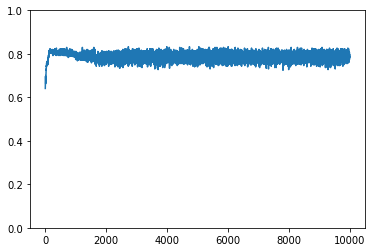

Max accuracy is: 84.16
   Epochs = 1773
   L-Rate = 0.0001


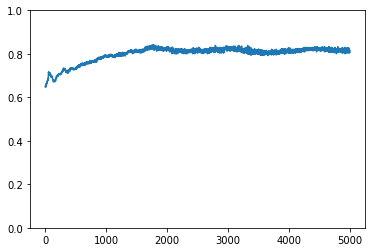

Max accuracy is: 83.33
   Epochs = 1644
   L-Rate = 0.001


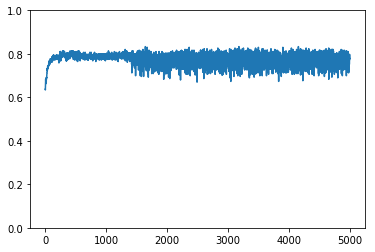

In [31]:
'''
Step 11:
    1. These 3 perceptron objects are for the real-valued scaled datasets
    2. They take the parameters from Step 9
        i. perceptron1 = split data
       ii. perceptron2 = unsplit data
      iii. perceptron3 = more split data
'''

perceptron1.fit(X_train_s1, y_train_s, e1, l1)
perceptron2.fit(X_train1, y_train, e2, l2)
perceptron3.fit(X_train_ss1, y_train_ss, e3, l3)

Max accuracy is: 85.45
   Epochs = 1650
   L-Rate = 0.0001


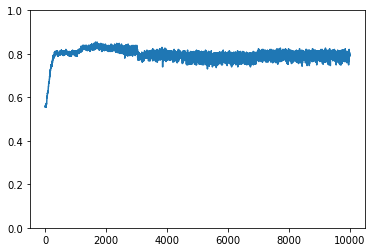

Max accuracy is: 85.63
   Epochs = 1891
   L-Rate = 0.0001


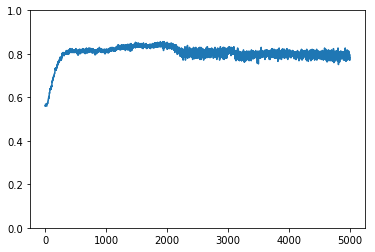

Max accuracy is: 83.66
   Epochs = 1076
   L-Rate = 0.0001


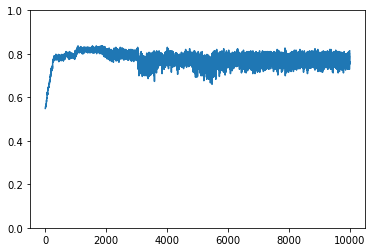

In [32]:
'''
Step 12:
    1. These 3 perceptron objects are for the real-valued scaled datasets
    2. They take the parameters from Step 10
        i. perceptron4 = split data
       ii. perceptron5 = unsplit data
      iii. perceptron6 = more split data
'''

perceptron4.fit(X_train_s2, y_train_s, e4, l4)
perceptron5.fit(X_train2, y_train, e5, l5)
perceptron6.fit(X_train_ss2, y_train_ss, e6, l6)

In [33]:
y_pred_test_s = perceptron1.predict(X_test_s1)
accuracy = accuracy_score(y_pred_test_s, y_test_s)
print(f'Accuracy score is {accuracy*100:0.2f}')

Accuracy score is 83.33


In [34]:
'''
Step 13: 
    Create wt_matrices to help plot the weights for real-value scaled perceptrons
'''

wt_matrix1 = pd.Series(perceptron1.w, index=cols)
wt_matrix2 =pd.Series(perceptron2.w, index=cols)
wt_matrix3 =pd.Series(perceptron3.w, index=cols)

In [35]:
'''
Step 14: 
    Create wt_matrices to help plot the weights for all-value scaled perceptrons
'''

wt_matrix4 = pd.Series(perceptron4.w, index=cols)
wt_matrix5 =pd.Series(perceptron5.w, index=cols)
wt_matrix6 =pd.Series(perceptron6.w, index=cols)

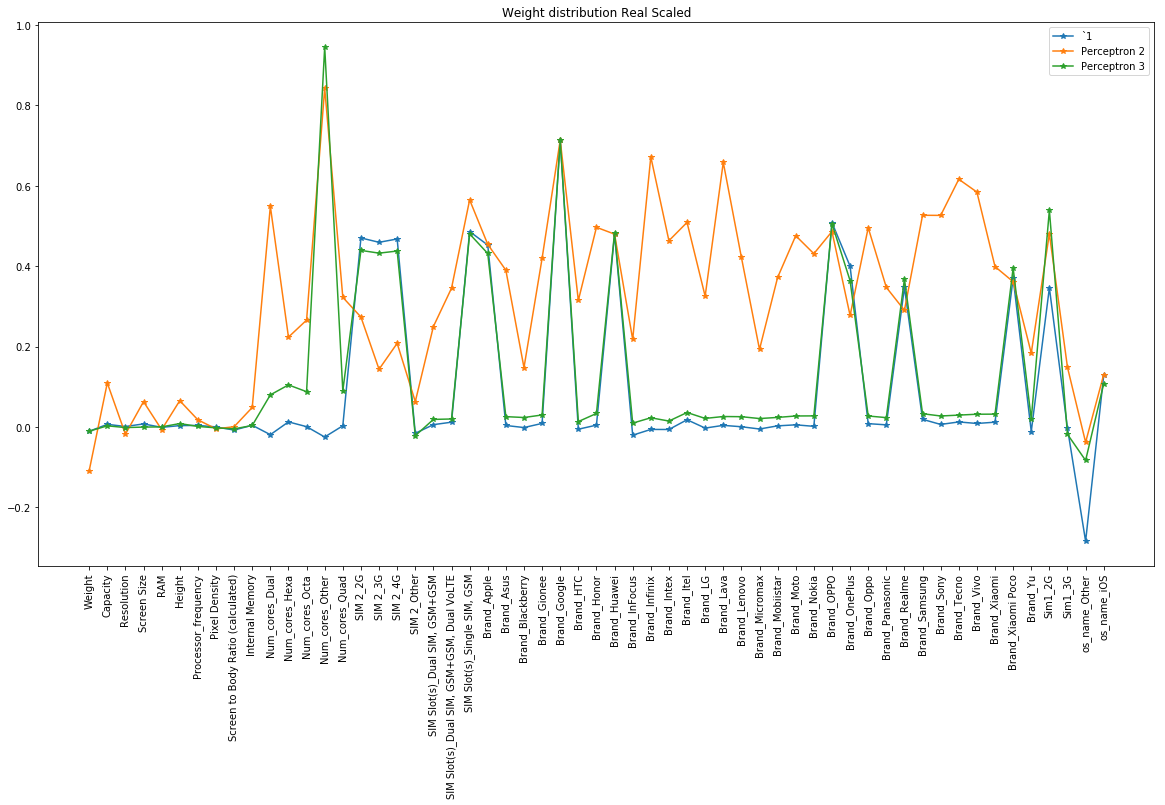

In [36]:
'''
Step 15:
    Plot Real Scaled matrices
'''

plt.figure(figsize=(20, 10))
plt.plot(wt_matrix1, '*-',label='`1')
plt.plot(wt_matrix2, '*-',label='Perceptron 2')
plt.plot(wt_matrix3, '*-',label='Perceptron 3')
plt.xticks(rotation='vertical')
plt.legend()
plt.title('Weight distribution Real Scaled')
plt.show()

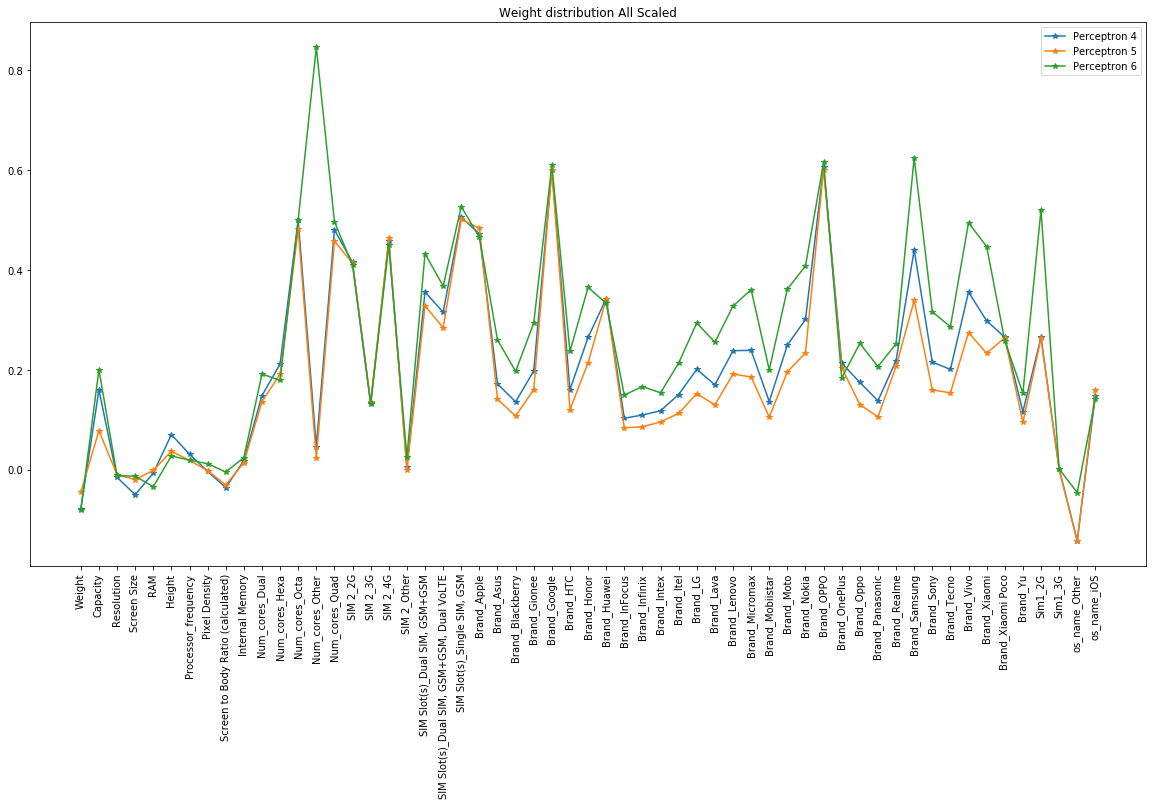

In [37]:
'''
Step 16:
    Plot All Scaled matrices
'''

plt.figure(figsize=(20, 10))
plt.plot(wt_matrix4, '*-',label='Perceptron 4')
plt.plot(wt_matrix5, '*-',label='Perceptron 5')
plt.plot(wt_matrix6, '*-',label='Perceptron 6')
plt.xticks(rotation='vertical')
plt.legend()
plt.title('Weight distribution All Scaled')
plt.show()

In [38]:
'''
Step 17:
    Create submission DataFrames for real-scaled perceptrons
'''

# Generating prediction vector on test set
y_pred1 = perceptron1.predict(X_test1)
submission1 = pd.DataFrame({'PhoneId': test_new1['PhoneId'], 'Class': y_pred1})
submission1 = submission1[['PhoneId', 'Class']]

y_pred2 = perceptron2.predict(X_test1)
submission2 = pd.DataFrame({'PhoneId': test_new1['PhoneId'], 'Class': y_pred2})
submission2 = submission2[['PhoneId', 'Class']]

y_pred3 = perceptron3.predict(X_test1)
submission3 = pd.DataFrame({'PhoneId': test_new1['PhoneId'], 'Class': y_pred3})
submission3 = submission3[['PhoneId', 'Class']]

In [39]:
'''
Step 18:
    Create submission DataFrames for all-scaled perceptrons
'''

# Generating prediction vector on test set
y_pred4 = perceptron4.predict(X_test2)
submission4 = pd.DataFrame({'PhoneId': test_new1['PhoneId'], 'Class': y_pred4})
submission4 = submission4[['PhoneId', 'Class']]

y_pred5 = perceptron5.predict(X_test2)
submission5 = pd.DataFrame({'PhoneId': test_new1['PhoneId'], 'Class': y_pred5})
submission5 = submission5[['PhoneId', 'Class']]

y_pred6 = perceptron6.predict(X_test2)
submission6 = pd.DataFrame({'PhoneId': test_new1['PhoneId'], 'Class': y_pred6})
submission6 = submission6[['PhoneId', 'Class']]

In [40]:
'''
Step 19:
    Creating dataframes to compare the values of real-scaled and all-scaled predictions
'''
result1 = pd.DataFrame({'Perceptron 1': submission1.Class, 'Perceptron 2': submission2.Class, 'Perceptron 3': submission3.Class})
result2 = pd.DataFrame({'Perceptron 4': submission4.Class, 'Perceptron 5': submission5.Class, 'Perceptron 6': submission6.Class})
result2

,Perceptron 4,Perceptron 5,Perceptron 6
0,1,1,1
1,0,0,0
2,1,1,1
3,1,1,1
4,1,1,1
5,0,1,0
6,0,0,0
7,1,1,1
8,1,1,1
9,1,1,0


In [41]:
list(result2['Perceptron 6'])

[1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1]

In [42]:
'''
Step 20:
    Creating 6 output files.
    NOTE:
    1. submission1 ie 'PerceptronRealScale1.csv' was the file submitted for grading.
    2. It scored 94% on the public leaderboard and 83% on the private leaderboard
'''

submission1.to_csv('PerceptronRealScale1.csv', index=False) # Submitted for final score.
submission2.to_csv('PerceptronRealScale2.csv', index=False)
submission3.to_csv('PerceptronRealScale3.csv', index=False)
submission4.to_csv('PerceptronAllScale1.csv', index=False)
submission5.to_csv('PerceptronAllScale2.csv', index=False)
submission6.to_csv('PerceptronAllScale3.csv', index=False)